In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix, cohen_kappa_score, precision_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
import math
from joblib import dump, load
import random
import pickle
import scipy.stats
from PIL import Image
import scipy.stats as stats

from Functions import post_processing
from Functions import general_functions
from Functions import feature_creation

from skimage.restoration import denoise_bilateral

In [2]:
import warnings
from numba.core.errors import NumbaPerformanceWarning

warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

### Loads all zones with their features and labels

In [3]:
file_list = [f"../zones_features_final/zone_{i}.pickle" for i in range(11, 22)]

### The following feature set was identified as the optimal in a tuning

In [4]:
features_to_use = ['impundment_mean_3', 'impundment_mean_4', 'hpmf_mean_4', 'impundment_mean_2',
                           'impundment_amplified', 'hpmf_median_4', 'impoundment_amplified_no_streams', 'hpmf_mean_3',
                           'skyview_max_6', 'slope_std_6', 'impundment_median_4', 'hpmf_min_2', 'hpmf_mean_6',
                           'skyview_max_4', 'slope_min_6', 'skyview_gabor', 'hpmf_min_4', 'skyview_gabor_no_streams',
                           'impundment_max_6', 'skyview_non_ditch', 'skyview_median_6', 'impundment_std_4', 'skyview_min_6',
                           'slope_min_4', 'slope_median_6', 'slope_std_4', 'impundment_median_2', 'skyview_max_2',
                           'impundment_median_6', 'hpmf_std_6', 'hpmf_gabor_no_streams', 'skyview_std_6', 'hpmf_filter',
                           'impundment_mean_6', 'slope_mean_6', 'slope_min_2', 'skyview_median_2', 'hpmf_filter_no_streams',
                           'impundment_std_6', 'slope_non_ditch']

### The following parameters were identified as the optimal in a tuning

In [5]:
params = {'criterion': 'gini',
   'max_depth': None,
   'min_samples_split': 10,
   'class_weight': None,
   'n_estimators': 300}

In [6]:
importances = np.empty((11,53), dtype=object)

predictions = np.empty((11, 3, 7852140))

### Performs 11 sub-experiments
Trains with 10 zones for each sub-experiment, and evaluates on one zone.
Each zone is evaluated once. Similar to cross validation but without randomly assigned subsets of data.
All of these 11 zones were hold-out data, which means that they had never before been used in our code.

In [7]:
for i, (training_files, test_file) in enumerate(general_functions.yield_training_test_zones(file_list)):
    training_dataset = general_functions.create_balanced_dataset(training_files)
    
    X_train = training_dataset.loc[:, training_dataset.columns != "label_3m"]
    X_train = X_train.filter(items=features_to_use)
    y_train = training_dataset["label_3m"]
    training_dataset = None
    
    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    clf.fit(X_train,y_train)
    
    test_dataset = pd.read_pickle(test_file)
    X_test = test_dataset.loc[:, test_dataset.columns != "label_3m"]
    X_test = X_test.filter(items=features_to_use)

    y_test = np.array(test_dataset["label_3m"])    
    
    proba = clf.predict_proba(X_test)[:,1:].reshape(2997,2620)
    
    proba_post_process = post_processing.proba_post_process(proba, 6, 0.4)
    
    labels_grid = post_processing.raster_to_zones(y_test.reshape(2997, 2620), 6, 4)
    
    experiment_preds = (proba.reshape(-1), proba_post_process.reshape(-1), labels_grid.reshape(-1))
    for j in range(3):
        predictions[i][j] = experiment_preds[j]

    experiment_importances = clf.feature_importances_
    feature_names = features_to_use
    tuple_features = [(feature_names[i], importance) for i, importance in enumerate(experiment_importances)]
    for j in range(len(feature_names)):
        importances[i][j] = (tuple_features[j][0], tuple_features[j][1]*100)

np.save("../revised_results/predictions.npy", predictions)
np.save("../revised_results/feature_importances_11_experiments.npy", importances)

E:\Skola\Examensarbete\Ditch-article-revision\Functions\post_processing.py:117: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "custom_remove_noise" failed type inference due to: Untyped global name 'd_gf': cannot determine Numba type of <class 'function'>

File "Functions\post_processing.py", line 122:
def custom_remove_noise(arr, radius, threshold, selfThreshold):
    <source elided>
    """
    max_arr = d_gf(da.from_array(arr, chunks=(800, 800)), np.nanmax,
    ^

  @jit
C:\Users\Jonatan\.conda\envs\pytorch\lib\site-packages\numba\core\object_mode_passes.py:177: NumbaWarning: Function "custom_remove_noise" was compiled in object mode without forceobj=True.

File "Functions\post_processing.py", line 118:
@jit
def custom_remove_noise(arr, radius, threshold, selfThreshold):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\Jonatan\.conda\envs\pytorch\lib\site-packages\numba\core\object_mode_passes.py:187: NumbaDeprecationWar

C:\Users\Jonatan\.conda\envs\pytorch\lib\site-packages\numba\core\object_mode_passes.py:177: NumbaWarning: Function "_get_cluster_array" was compiled in object mode without forceobj=True.

File "Functions\post_processing.py", line 157:
@jit
def _get_cluster_array(arr, index, zoneSize):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\Jonatan\.conda\envs\pytorch\lib\site-packages\numba\core\object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "Functions\post_processing.py", line 157:
@jit
def _get_cluster_array(arr, index, zoneSize):
^

  warnings.warn(errors.NumbaDeprecationWarning(msg,


### Loads saved experiment results from file

In [8]:
predictions = np.load("../revised_results/predictions.npy")
prediction2d = np.concatenate(predictions, axis= 1)
y_pred_all = prediction2d[1]
y_test_all = prediction2d[2]

In [9]:
predictions = predictions.reshape(11, 3, 2997, 2620)

## Modifying evaluation labels

In [10]:
for i in range(predictions.shape[0]):
    pred = predictions[i, 1]
    labels = predictions[i, 2]
    new_labels = labels.copy()
    false_positives = np.zeros(pred.shape)
    false_negatives = np.zeros(pred.shape)
    for j in range(pred.shape[0]):
        for k in range(pred.shape[1]):
            if pred[j, k] == 1 and labels[j, k] == 0:
                false_positives[j, k] = 1
            elif pred[j, k] == 0 and labels[j, k] == 1:
                false_negatives[j, k] = 1
    for j in range(0, len(pred) - 6, 6):
        for k in range(0, len(pred[i]) - 6, 6):
            if false_positives[j, k] == 1:
                if labels[j+6, k] == 1 or labels[j-6, k] == 1 or labels[j, k+6] == 1 or labels[j, k-6] == 1:
                    for l in range(j, j+6):
                        for m in range(k, k+6):
                            new_labels[l, m] = 1
            if false_negatives[j, k] == 1:
                if pred[j+6, k] == 1 or pred[j-6, k] == 1 or pred[j, k+6] == 1 or pred[j, k-6] == 1:
                    for l in range(j, j+6):
                        for m in range(k, k+6):
                            new_labels[l, m] = 0
                            
    np.save(f"../revised_results/new_labels_zone_{i+1}.npy", new_labels)

In [11]:
predictions = np.load("../revised_results/predictions.npy")
prediction2d = np.concatenate(predictions, axis= 1)
y_pred_all = prediction2d[1]
y_test_all = np.load("../revised_results/new_labels_zone_1.npy").reshape(-1)
for i in range (2, 12):
    y_test_all = np.append(y_test_all, np.load(f"../revised_results/new_labels_zone_{i}.npy").reshape(-1))

## Experiment metrics

In [12]:
print("Accuracy score             ", accuracy_score(y_test_all, y_pred_all))
print("Recall score               ", recall_score(y_test_all, y_pred_all))
print("Precision score            ", precision_score(y_test_all, y_pred_all))
precision, recall, threshholds = precision_recall_curve(y_test_all,y_pred_all)
auc_score = auc(recall, precision)
print("Cohen's kappa score        ", cohen_kappa_score(y_test_all, y_pred_all))
print("AUPRC score                ", auc_score)
print("Confusion matrix\n", confusion_matrix(y_test_all, y_pred_all))

Accuracy score              0.9900159817462616
Recall score                0.702800840456131
Precision score             0.7738246505717916
Cohen's kappa score         0.7315282188287252
AUPRC score                 0.7412645464937522
Confusion matrix
 [[84305365   352440]
 [  509915  1205820]]


In [13]:
metrics_per_zone = []
for i, zone in enumerate(predictions):
    proba, binary_prediction, old_labels = zone
    labels_grid = np.load(f"../revised_results/new_labels_zone_{i+1}.npy").reshape(-1)
    acc = accuracy_score(labels_grid, binary_prediction)
    _recall = recall_score(labels_grid, binary_prediction)
    _precision = precision_score(labels_grid, binary_prediction)
    kappa = cohen_kappa_score(labels_grid, binary_prediction)
    precision, recall, threshholds = precision_recall_curve(labels_grid, binary_prediction)
    auc_score = auc(recall, precision)
    metrics = (acc, _recall, _precision, kappa, auc_score)
    metrics_per_zone.append(metrics)
    print(f"Zone {i+1}:\nAccuracy: {metrics[0]}, Recall: {metrics[1]}, Precision: {metrics[2]}, Cohen's Kappa: {metrics[3]}, AUPRC: {metrics[4]}\n")


Zone 1:
Accuracy: 0.9892237020735748, Recall: 0.646971640491556, Precision: 0.7555183012014529, Cohen's Kappa: 0.6915921870036359, AUPRC: 0.7046272971932075

Zone 2:
Accuracy: 0.977198445264603, Recall: 0.6504216872375482, Precision: 0.8266269249875807, Cohen's Kappa: 0.7162911387170026, AUPRC: 0.7467249367686659

Zone 3:
Accuracy: 0.9875684845150494, Recall: 0.6389821882951654, Precision: 0.7699288692666176, Cohen's Kappa: 0.6920797442732336, AUPRC: 0.7085210446784684

Zone 4:
Accuracy: 0.9860972932219751, Recall: 0.7958004741400164, Precision: 0.7106859542697154, Cohen's Kappa: 0.743711408470012, AUPRC: 0.7559307618033551

Zone 5:
Accuracy: 0.9876060538910412, Recall: 0.7582336920553044, Precision: 0.8361464968152866, Cohen's Kappa: 0.788911721647708, AUPRC: 0.8010282200927595

Zone 6:
Accuracy: 0.9890153512290917, Recall: 0.3448254344638233, Precision: 0.587747287811104, Cohen's Kappa: 0.4294810868043135, AUPRC: 0.47029781533975756

Zone 7:
Accuracy: 0.9926898909087204, Recall: 0.84

In [14]:
def mean_confidence_interval(data, confidence = 0.95):
    sample = np.array(data)
    sample_size, sample_mean = len(sample), sample.mean()
    z_critical = stats.norm.ppf(q = ((1+confidence) / 2.))  # Get the z-critical value*
    margin_of_error = z_critical * (sample.std() / math.sqrt(sample_size))
    return (sample_mean, sample_mean - margin_of_error, sample_mean + margin_of_error)

In [15]:
metric_names = ["accuracy", "recall", "precision", "Cohen's Kappa", "AUPRC"]
avg = 0
for i in range(0, 5):
    for interval in [0.90, 0.95, 0.99]:
        conf_int = mean_confidence_interval([j[i] for j in metrics_per_zone], interval)
        avg = conf_int[0]
        print(f"Confidence interval for {metric_names[i]} at {interval * 100}%: [{conf_int[1]}, {conf_int[2]}]")
    print(f"Average for {metric_names[i]}: {avg}")
    print("\n")

Confidence interval for accuracy at 90.0%: [0.9873725751282527, 0.9926593883642705]
Confidence interval for accuracy at 95.0%: [0.986866168484522, 0.9931657950080012]
Confidence interval for accuracy at 99.0%: [0.9858764254256899, 0.9941555380668333]
Average for accuracy: 0.9900159817462616


Confidence interval for recall at 90.0%: [0.6271172006678419, 0.7766282036486803]
Confidence interval for recall at 95.0%: [0.6127960279991114, 0.7909493763174109]
Confidence interval for recall at 99.0%: [0.5848061083985501, 0.8189392959179722]
Average for recall: 0.7018727021582611


Confidence interval for precision at 90.0%: [0.725628742051088, 0.7901763058907042]
Confidence interval for precision at 95.0%: [0.7194459408614555, 0.7963591070803366]
Confidence interval for precision at 99.0%: [0.707362006660877, 0.8084430412809152]
Average for precision: 0.7579025239708961


Confidence interval for Cohen's Kappa at 90.0%: [0.6650466616383834, 0.7709392843263478]
Confidence interval for Cohen's K

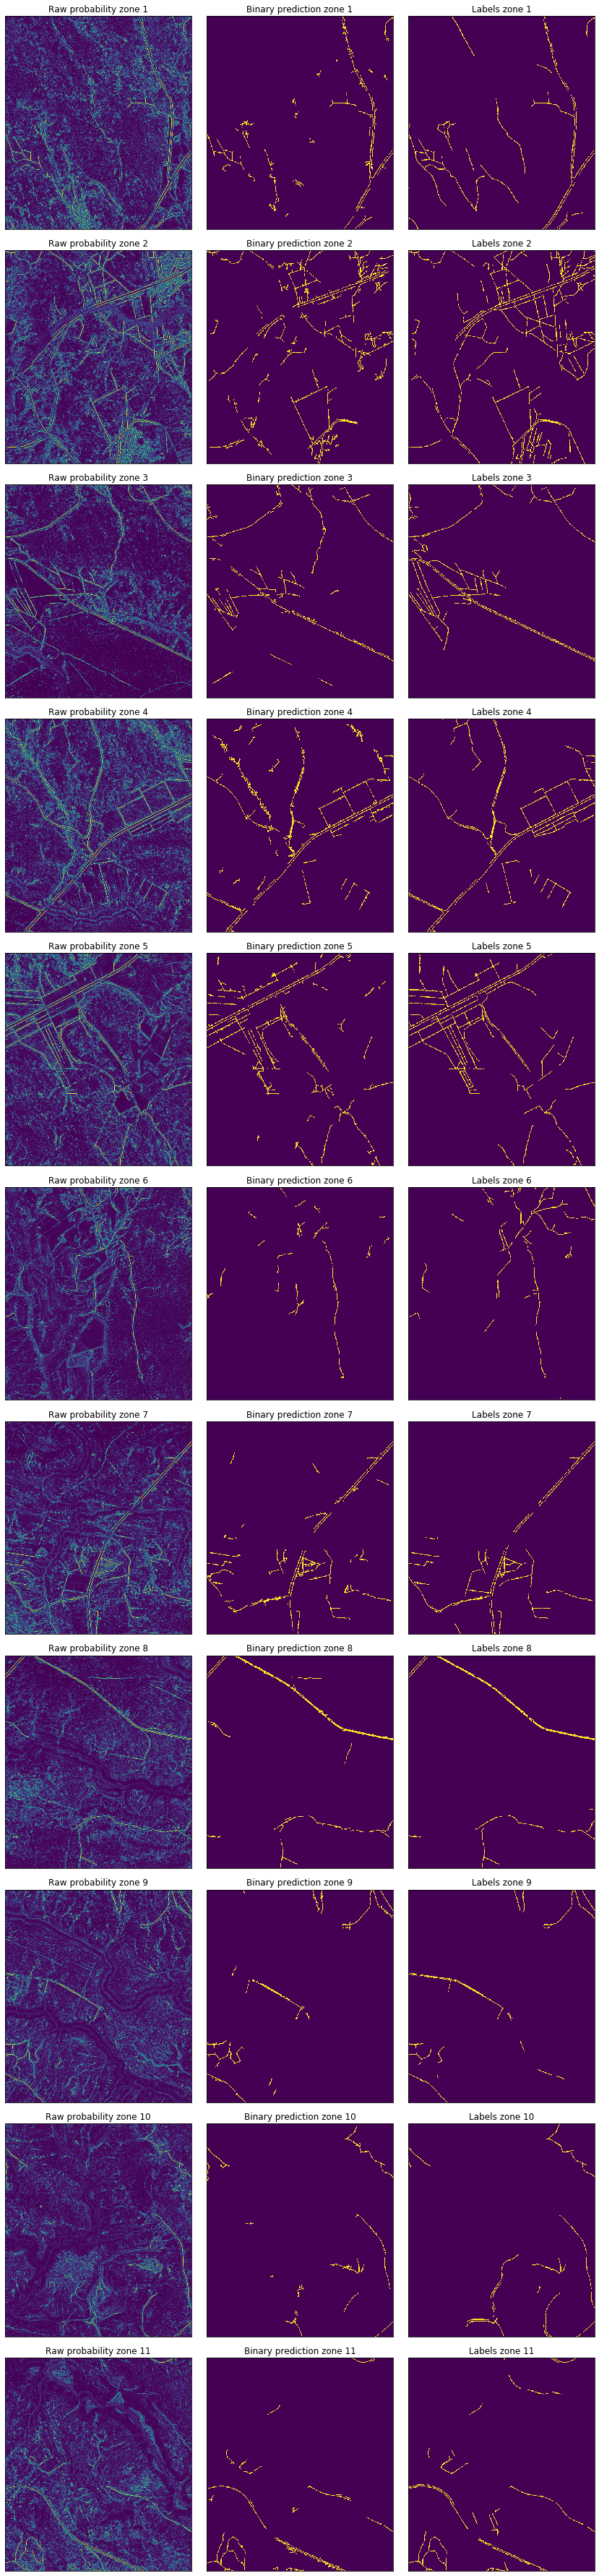

In [16]:
plt.figure(num=None, figsize=(15,65), facecolor='w', edgecolor='k')
ax = [plt.subplot(11,3,i+1) for i in range(33)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

for i, zone_pred in enumerate(predictions):
    ax[i*3].title.set_text(f"Raw probability zone {i+1}")
    ax[i*3].imshow(zone_pred[0].reshape(2997,2620))
    ax[i*3+1].title.set_text(f"Binary prediction zone {i+1}")
    ax[i*3+1].imshow(zone_pred[1].reshape(2997,2620))
    ax[i*3+2].title.set_text(f"Labels zone {i+1}")
    ax[i*3+2].imshow(np.load(f"../revised_results/new_labels_zone_{i+1}.npy"))

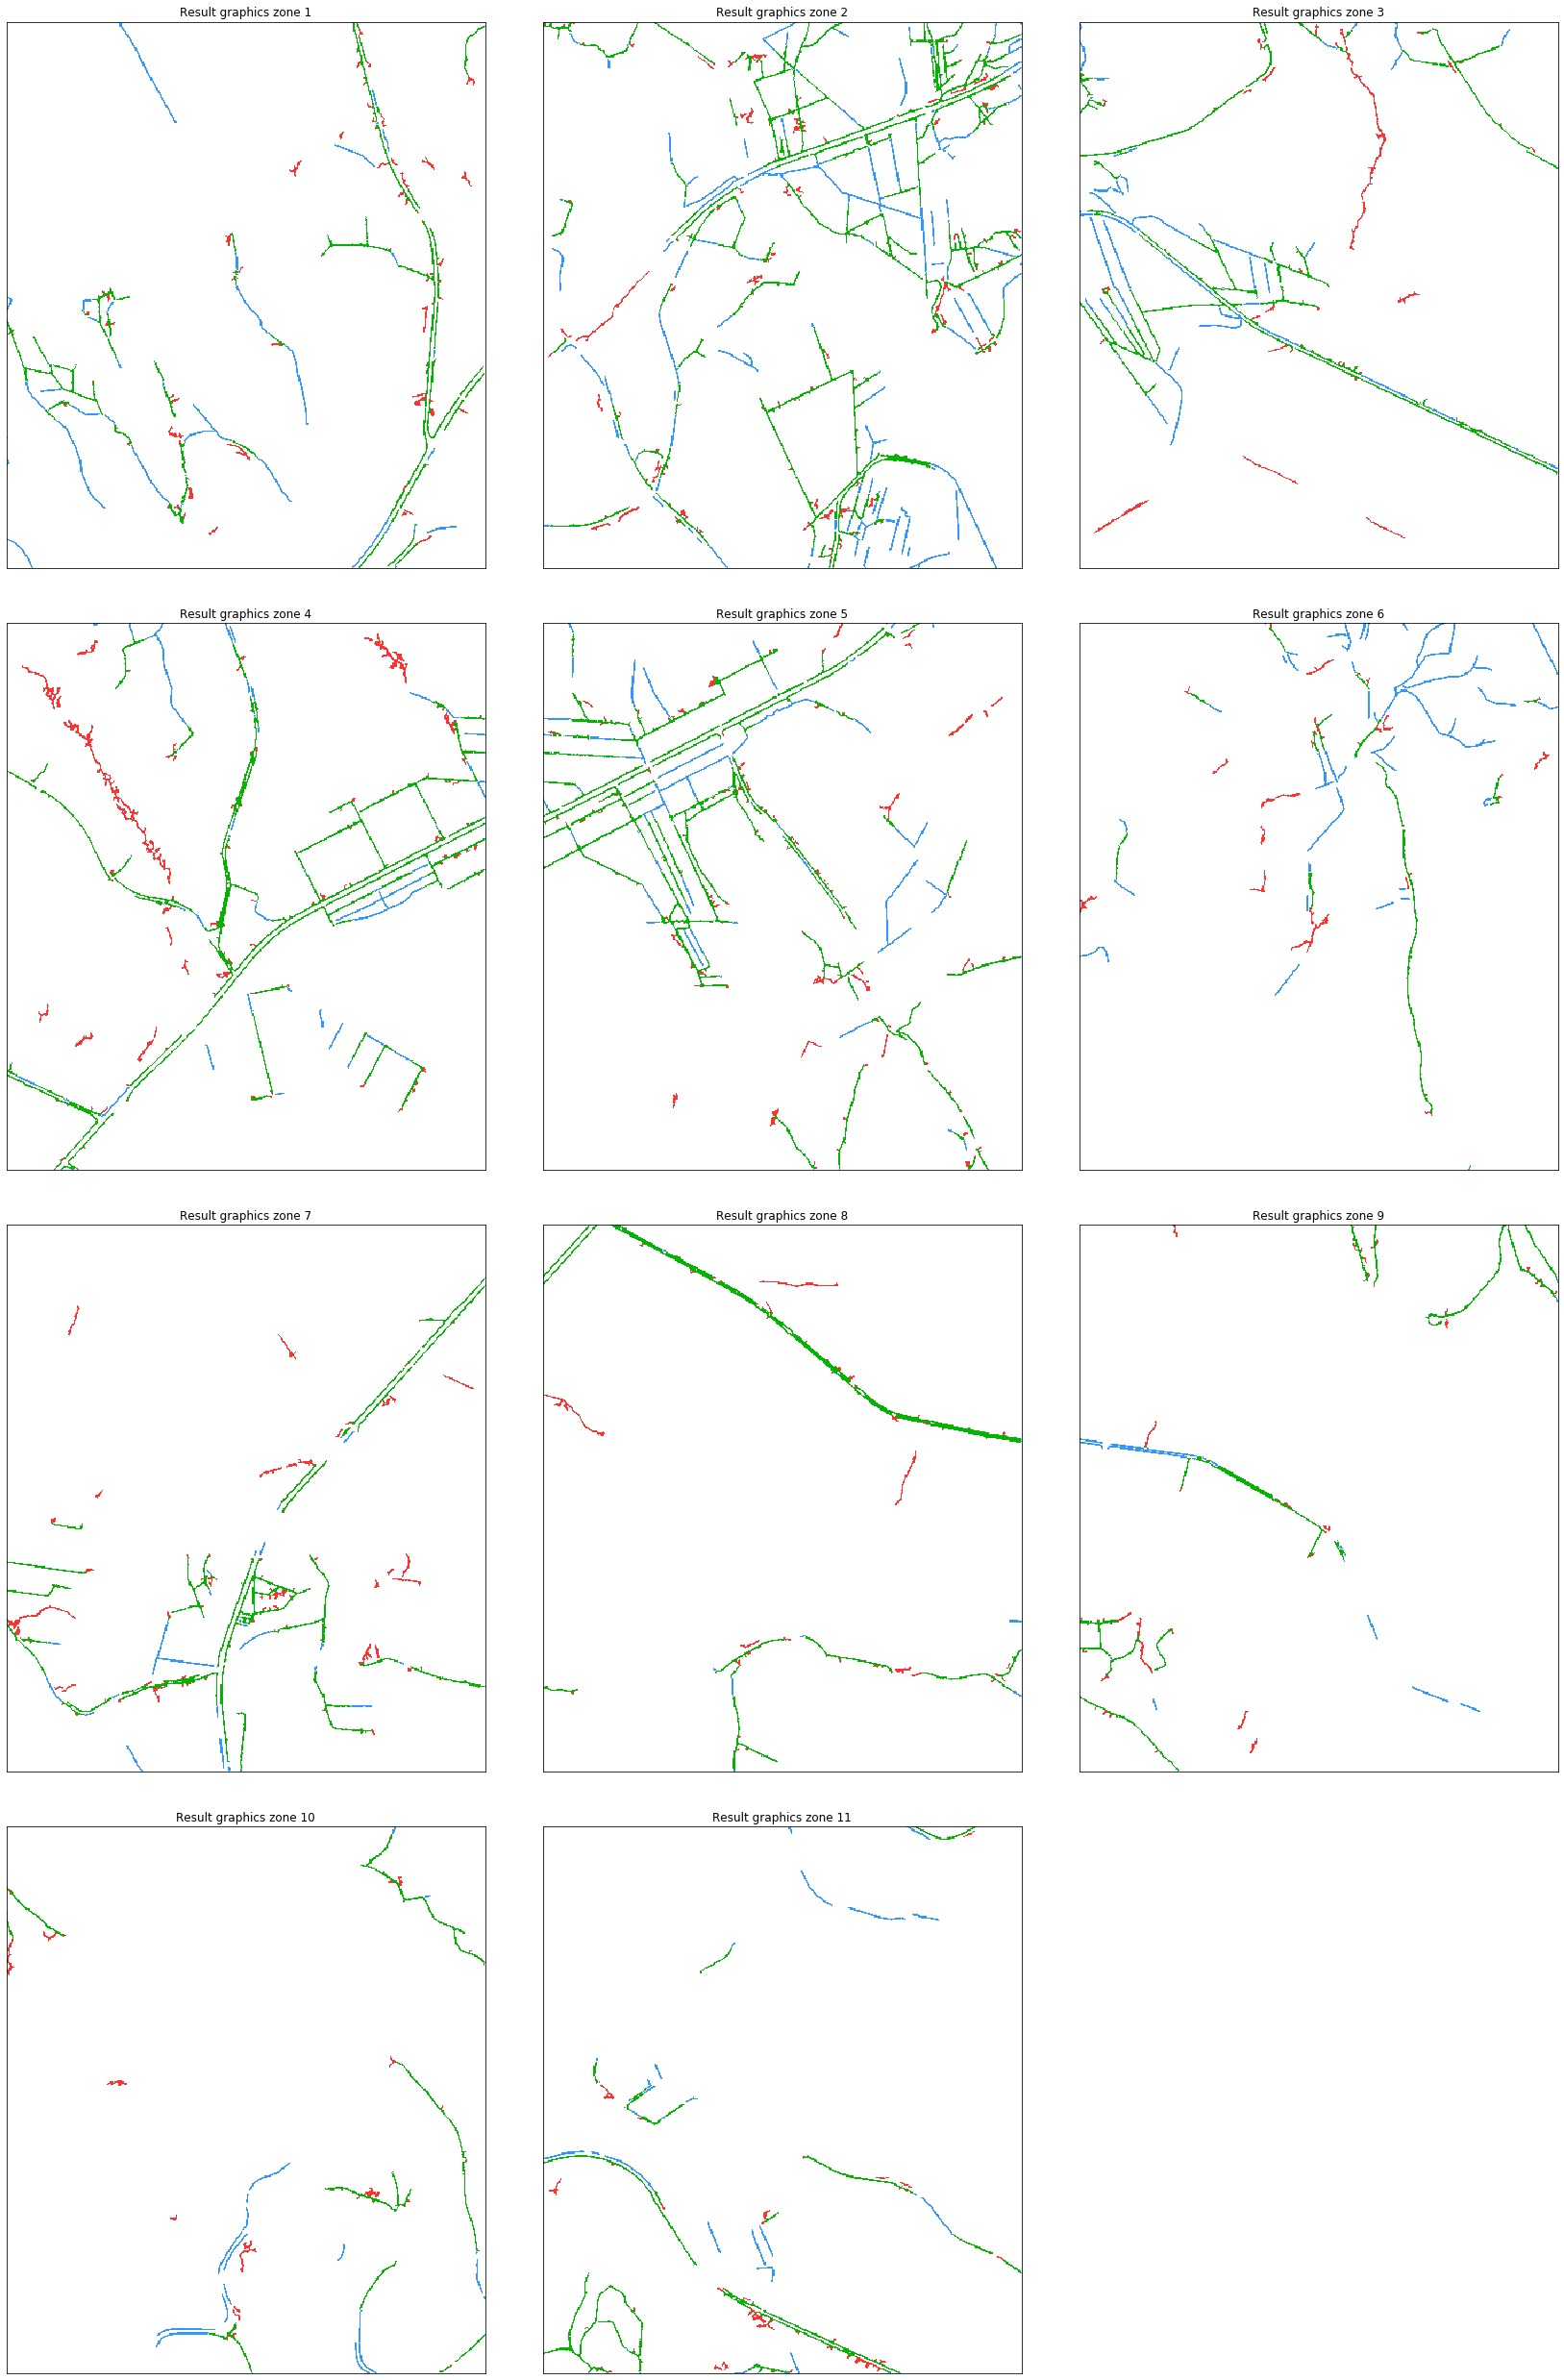

In [17]:
plt.figure(num=None, figsize=(30,45), facecolor='w', edgecolor='k')
ax = [plt.subplot(4,3,i+1) for i in range(11)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

for k, zone_pred in enumerate(predictions):
    validation = np.load(f"../revised_results/new_labels_zone_{k+1}.npy")
    pred = zone_pred[1].reshape(2997,2620)
    displayImg = Image.new("RGB", (2620, 2997), "white")
    pixels = displayImg.load()
    for i in range(displayImg.size[0]):
        for j in range(displayImg.size[1]):
            if validation[j][i] == 1 and pred[j][i] == 1:
                pixels[i,j] = (0, 180, 0)
            elif validation[j][i] == 1 and pred[j][i] == 0:
                pixels[i,j] = (50, 150, 255)
            elif validation[j][i] == 0 and pred[j][i] == 1:
                pixels[i,j] = (255, 50, 50)
    
    ax[k].title.set_text(f"Result graphics zone {k+1}")
    ax[k].imshow(displayImg)